# Behavior Session Ingestion

## Setup

### Connect to the database

If you are don't have your login information, contact the administrator.

Using local config file (see [01_pipeline](./01_pipeline.ipynb)):

Check out the respective elements video: https://www.youtube.com/watch?v=DLYqnj40eAM

Use this as info NB https://github.com/SFB1089/workflow-calcium-imaging/blob/main/notebooks/07-downstream-analysis-optional.ipynb


In [1]:
import os
# change to the upper level folder to detect dj_loc<al_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()


[2023-11-22 14:18:33,313][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-11-22 14:18:33,362][INFO]: Connected tobiasr@172.26.128.53:3306


DataJoint connection (connected) tobiasr@172.26.128.53:3306

Manual entry:

### Imports and activation

Importing schema from `adamacs.pipeline` automatically activates relevant schema.

In [2]:
from adamacs.pipeline import subject, session, surgery, scan, event, trial, imaging, behavior
from adamacs import utility
from adamacs.ingest import behavior as ibe
from pywavesurfer import ws
import matplotlib.pyplot as plt
import numpy as np
# check https://elements.datajoint.org/description/event/ for doc

Assign easy names for relevant tables

In [3]:
sub, lab, protocol, line, mutation, user, project, subject_genotype, subject_death = (
    subject.Subject(), subject.Lab(), subject.Protocol(), subject.Line(), 
    subject.Mutation(), subject.User(), subject.Project(), subject.SubjectGenotype(), 
    subject.SubjectDeath())

## Ingesting behavior

In [4]:
scan.ScanInfo() & subject.User()

session_id,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan,userfunction_info string argument of file consolidation userfunction 1
sess9FKMRSOL,scan9FKMRSOL,1,1,1,120300,0,22785.7,23042.6,49203.6,29.9784,1,63.1769,0.712867,None,4012.89,bench2p


In [5]:
# scansi = "scan9FJ4IJOQ"
scansi = "scan9FKMRSOL"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
sessi = (scan.Scan & f'scan_id = "{scansi}"').fetch('session_id')[0]
aux_setup_typestr = (scan.ScanInfo() & scan_key).fetch("userfunction_info")[0]

# ibe.ingest_aux(sessi,scansi,verbose=False, aux_setup_type=aux_setup_typestr)

In [6]:
scan.ScanInfo() & scan_key

session_id,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan,userfunction_info string argument of file consolidation userfunction 1
sess9FKMRSOL,scan9FKMRSOL,1,1,1,120300,0,22785.7,23042.6,49203.6,29.9784,1,63.1769,0.712867,None,4012.89,bench2p


In [7]:
event.Event & scan_key 

session_id,scan_id,event_type,event_start_time (second) relative to recording start,event_end_time (second) relative to recording start
sess9FKMRSOL,scan9FKMRSOL,aux_cam,0.99995,1.00495
sess9FKMRSOL,scan9FKMRSOL,aux_cam,1.01665,1.02165
sess9FKMRSOL,scan9FKMRSOL,aux_cam,1.03335,1.03835
sess9FKMRSOL,scan9FKMRSOL,aux_cam,1.05005,1.05505
sess9FKMRSOL,scan9FKMRSOL,aux_cam,1.06675,1.07175
sess9FKMRSOL,scan9FKMRSOL,aux_cam,1.08345,1.08845
sess9FKMRSOL,scan9FKMRSOL,aux_cam,1.10015,1.10515
sess9FKMRSOL,scan9FKMRSOL,aux_cam,1.11685,1.12185
sess9FKMRSOL,scan9FKMRSOL,aux_cam,1.13355,1.13855
sess9FKMRSOL,scan9FKMRSOL,aux_cam,1.15025,1.15525


In [8]:
set((event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_type"))

{'Natural Image:2144;Natural Images;0;10;50:50;0;0;0;',
 'Natural Image:3066;Natural Images;0;10;50:50;0;0;0;',
 'Natural Image:237;Natural Images;0;10;50:50;0;0;0;',
 'Natural Image:1856;Natural Images;0;10;50:50;0;0;0;',
 'Natural Image:1069;Natural Images;0;10;50:50;0;0;0;',
 'Natural Image:16;Natural Images;0;10;50:50;0;0;0;',
 'Natural Image:3104;Natural Images;0;10;50:50;0;0;0;',
 'Natural Image:1825;Natural Images;0;10;50:50;0;0;0;',
 'Natural Image:1026;Natural Images;0;10;50:50;0;0;0;',
 'Natural Image:3012;Natural Images;0;10;50:50;0;0;0;',
 'Natural Image:3073;Natural Images;0;10;50:50;0;0;0;',
 'Natural Image:417;Natural Images;0;10;50:50;0;0;0;',
 'Natural Image:89;Natural Images;0;10;50:50;0;0;0;',
 'Natural Image:1045;Natural Images;0;10;50:50;0;0;0;',
 'Natural Image:3106;Natural Images;0;10;50:50;0;0;0;',
 'Natural Image:3535;Natural Images;0;10;50:50;0;0;0;',
 'Natural Image:628;Natural Images;0;10;50:50;0;0;0;',
 'Natural Image:3134;Natural Images;0;10;50:50;0;0;0;',

In [9]:
stims_per_trial = len(set((event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_type")))
all_stims = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_type")
trial_stims = {x: list(all_stims).count(x) for x in all_stims}
trials = set([list(all_stims).count(x) for x in all_stims])
total_trials = len(all_stims)

print("Unique Stims " + str(stims_per_trial))
# print(trial_stims)
print("Repetitions of Unique Stims " +  str(trials))
print("Total number of Stims " + str(total_trials))


Unique Stims 4000
Repetitions of Unique Stims {1}
Total number of Stims 4000


In [ ]:
trial_start_edges = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_start_time",order_by = "event_start_time")[::stims_per_trial] 
trial_end_edges = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_end_time",order_by = "event_end_time")[stims_per_trial-1::stims_per_trial] 
trial_event_name = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_type")[0].split(':')[0]
# trial.TrialType().insert1({'trial_type': trial_event_name, 'trial_type_description': ''}, skip_duplicates=True) 

In [ ]:
(event.Event & scan_key & 'event_type LIKE "%;%"').fetch(format = "frame",order_by = "event_start_time")

In [ ]:
trial.TrialType()  & scan_key

In [ ]:
trial_start_edges

In [ ]:
trial_end_edges

In [ ]:
event_names = (event.Event & scan_key & 'event_type LIKE "%;%"' & f"event_end_time ").fetch("event_type",order_by = "event_start_time")
event_onsets = (event.Event & scan_key & 'event_type LIKE "%;%"' & f"event_end_time < {trial_end_edges[0]}").fetch("event_start_time",order_by = "event_start_time")

In [ ]:
len(event_names)

# Ingestions!

In [ ]:
ibe.ingest_aux(sessi,scansi, verbose=True, aux_setup_type="bench2p")

In [ ]:

# ibe.ingest_aux(sessi,scansi, verbose=True, aux_setup_type="bench2p")
ibe.get_and_ingest_trial_times(scansi, aux_setup_typestr)     

# example queries

In [ ]:
scansi = "scan9FKMRSOL"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 

(event.Event & scan_key & f'event_type LIKE "%;%"').fetch(format = "frame", order_by = "event_start_time")

In [ ]:
# example: get stimulus onsets and offsets of certain trials fro a single stimulus

scansi = "scan9FK60H47"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 

orientation = "Noise"

trialnum = 1
dataframe = (event.Event * trial.TrialEvent & scan_key & f'event_type LIKE "%{orientation}%"' & f"trial_id <= {trialnum}").fetch(format = "frame")
dataframe

In [ ]:
# example: get stimulus onsets and offsets of certain trials of a single stimulus as dataframe

scansi = "scan9FK60H47"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 

dataframe = (event.Event  & scan_key & f'event_type LIKE "%;%"' ).fetch(format = "frame", order_by = "event_start_time")
dataframe

In [ ]:
# example: get stimulus onsets and offsets of certain trials fro a single stimulus
temporal_freq = (event.Event * trial.TrialEvent & scan_key & f'event_type LIKE "%{orientation}%"' & f"trial_id <= {trialnum}").fetch("event_type")[0].split(";")[7]

print(temporal_freq)

In [ ]:
trialnum = 1 # 1-indexed!
TrialEvent_query_keys = (event.Event * trial.Trial & scan_key & f'event_type LIKE "%;%"' & f'event_start_time <= "{trial_end_edges[trialnum-1]}"' & f'event_end_time >= "{trial_start_edges[trialnum-1]}"' & f'trial_id= "{trialnum}"').fetch(format = "frame", order_by = "event_start_time")

#  Plot the aux file

In [10]:
from element_interface.utils import find_full_path
from adamacs.paths import get_experiment_root_data_dir

bpod_path_relative = (event.BehaviorRecording.File & scan_key).fetch1("filepath")
auxpath = list(find_full_path(
    get_experiment_root_data_dir(), bpod_path_relative
).parent.glob("*h5"))

print(auxpath)

[PosixPath('/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-10-17_scan9FKMRSOL_sess9FKMRSOL/scan9FKMRSOL_LE_WEZ-8909_0001.h5')]


In [11]:
aux_setup_typestr = (scan.ScanInfo() & 'scan_id = "' + scansi + '"').fetch("userfunction_info")[0]
aux_setup_typestr

'bench2p'

In [12]:
curr_file = ws.loadDataFile(filename=auxpath[0], format_string='double' )

/home/tobiasr/miniconda3/envs/dj_pure/lib/python3.8/site-packages/pywavesurfer/ws.py:46: RuntimeWarning: You are reading a WaveSurfer file version this module was not tested with: file version 1.0.6, latest version tested: 0.982
  warnings.warn('You are reading a WaveSurfer file version this module was not tested with: '


In [13]:
sweep = [x for x in curr_file.keys() if 'sweep' in x][0]

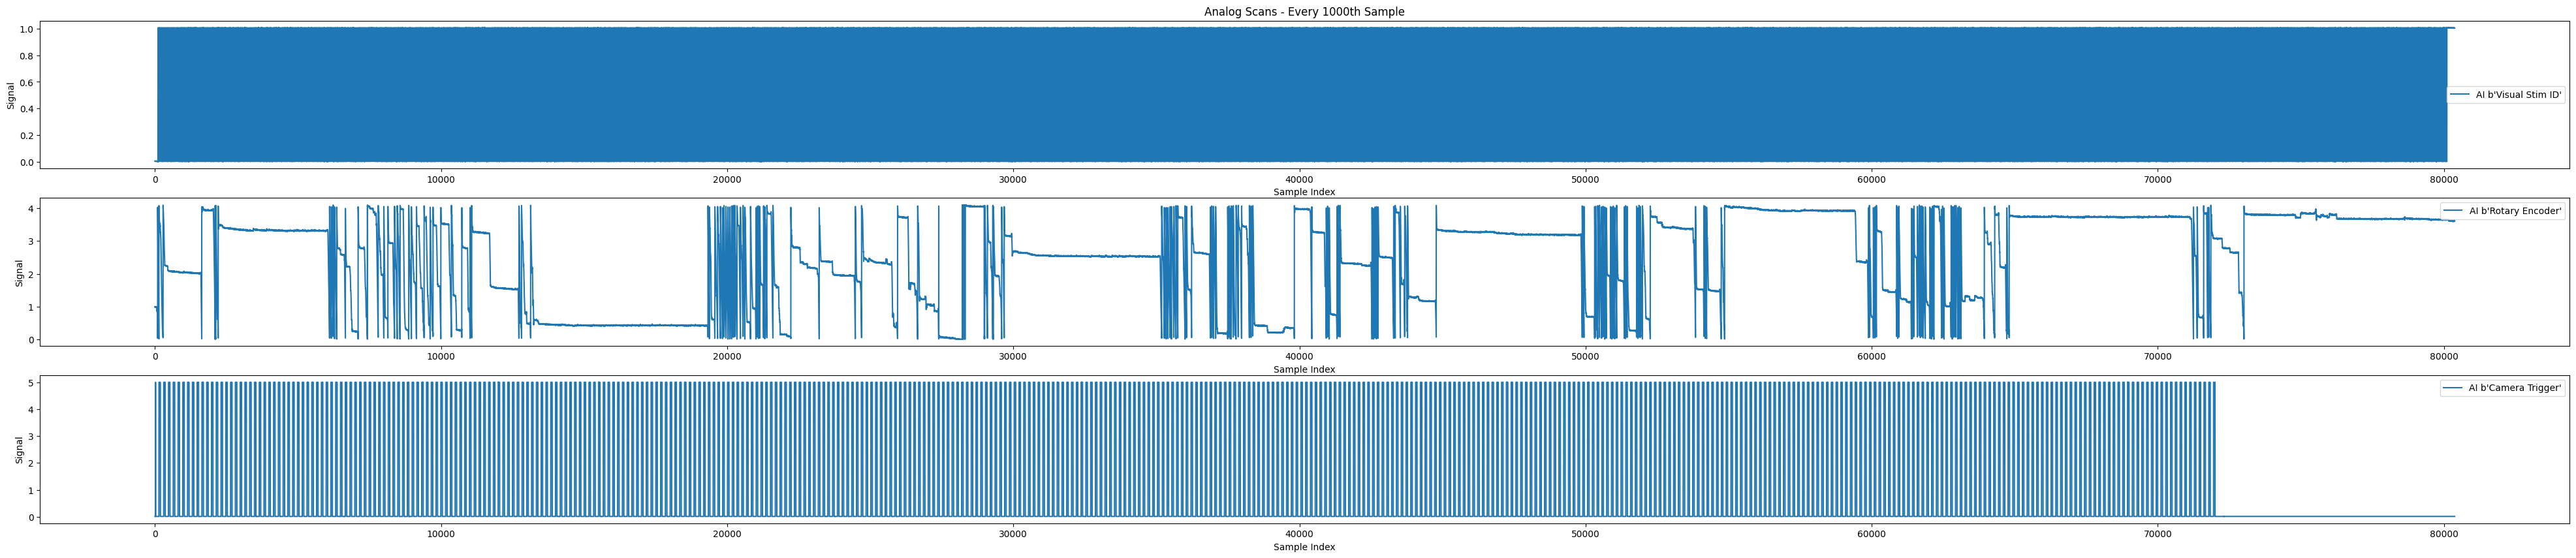

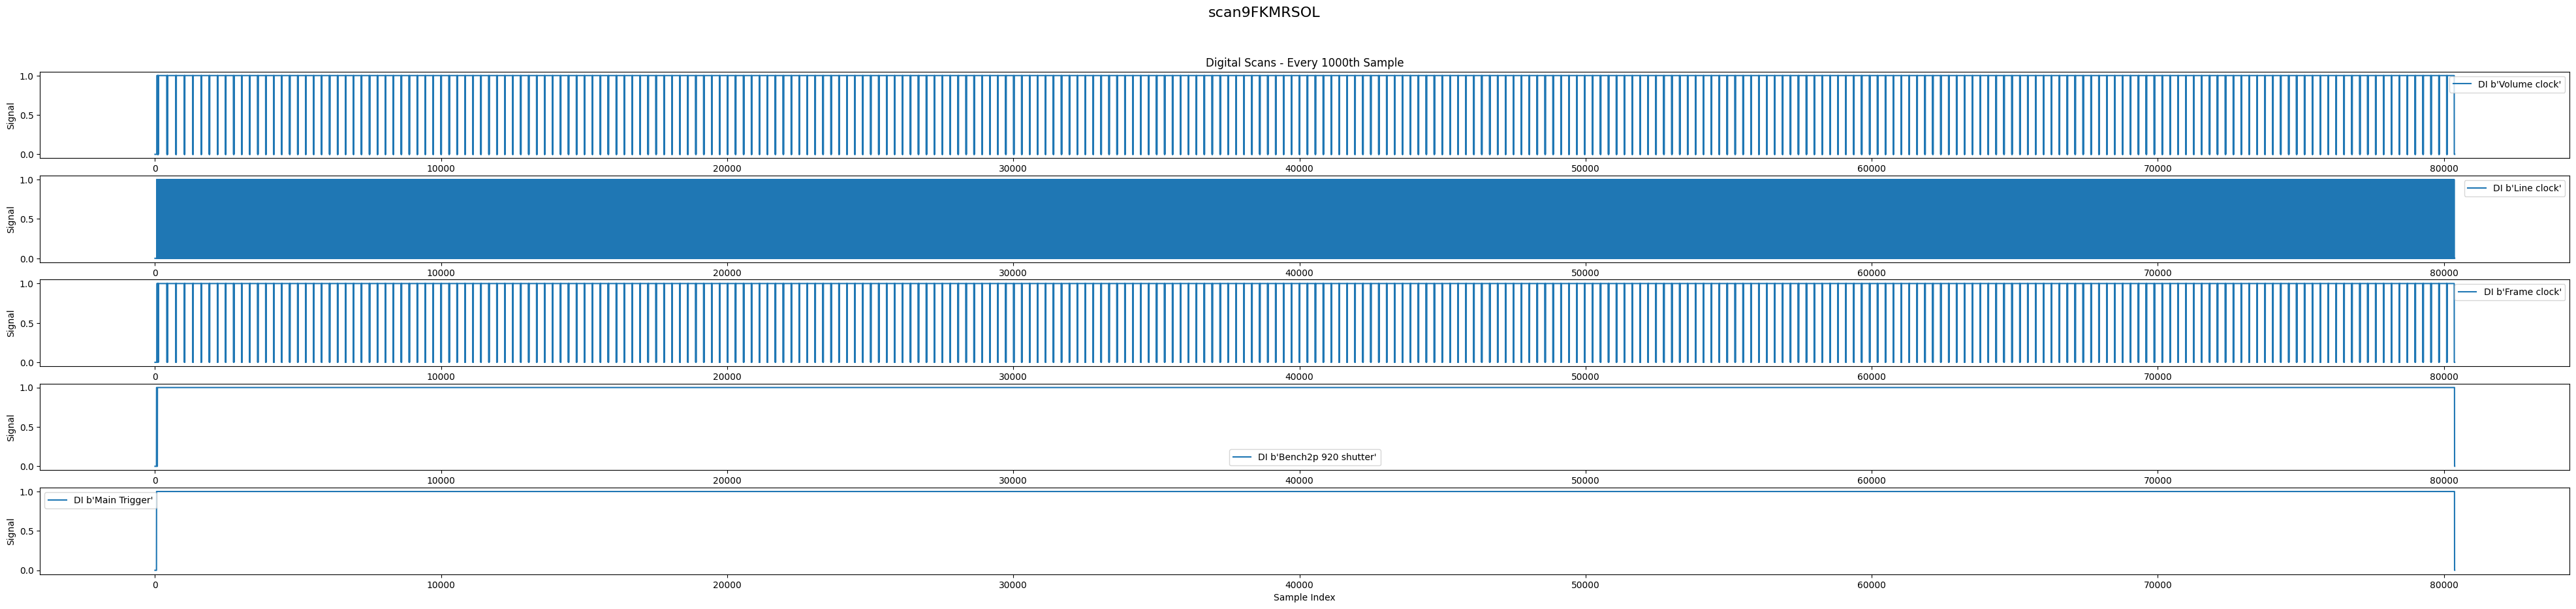

In [14]:
import numpy as np

analog_scans = curr_file[sweep]['analogScans']
analog_labels = curr_file['header']['AIChannelNames']
digital_labels = curr_file['header']['DIChannelNames']
sr = curr_file['header']['AcquisitionSampleRate'][0][0]
digital_scans = ibe.demultiplex(curr_file[sweep]['digitalScans'][0], np.shape(digital_labels)[0])
step = 1000

# Plotting analogScans
# plt.figure(figsize=(12, 6))
# plt.title("Analog Scans")

# Creating subplots
fig, axes = plt.subplots(nrows=analog_scans.shape[0], ncols=1, figsize=(50, 10))

# Plotting analogScans
axes[0].set_title(f"Analog Scans - Every {step}th Sample")
for i in range(analog_scans.shape[0]):
     axes[i].plot(analog_scans[i][::step], label=f"AI {analog_labels[i]}")
     axes[i].legend()
     axes[i].set_xlabel("Sample Index")
     axes[i].set_ylabel("Signal")

plt.show()


# Creating subplots
fig, axes = plt.subplots(nrows=digital_scans.shape[0], ncols=1, figsize=(50, 10))

# Plotting analogScans
axes[0].set_title(f"Digital Scans - Every {step}th Sample")
for i in range(digital_scans.shape[0]):
     axes[i].plot(digital_scans[i][::step], label=f"DI {digital_labels[::-1][i]}")
     axes[i].set_xlabel("Sample Index")
     axes[i].set_ylabel("Signal")
     axes[i].legend()
     # axes.xlim(0, 10000)
fig.suptitle(scan_key["scan_id"], fontsize=16)


plt.show()


In [ ]:
step = 100

# Plotting analogScans
axes[0].set_title(f"Analog Scans - Every {step}th Sample")
for i in range(analog_scans.shape[0]):
     axes[i].plot(analog_scans[i][::step], label=f"AI {analog_labels[i]}")
     axes[i].legend()
     axes[i].set_xlim([xmin, xmax]) 
     axes[i].set_xlabel("Sample Index")
     axes[i].set_ylabel("Signal")

plt.show()


# Creating subplots
fig, axes = plt.subplots(nrows=digital_scans.shape[0], ncols=1, figsize=(50, 10))

xmin = 0
xmax = 100000

# Plotting analogScans
axes[0].set_title(f"Digital Scans - Every {step}th Sample")
for i in range(digital_scans.shape[0]):
     axes[i].plot(digital_scans[i][::step], label=f"DI {digital_labels[::-1][i]}")
     axes[i].set_xlabel("Sample Index")
     axes[i].set_ylabel("Signal")
     axes[i].legend()
     axes[i].set_xlim([xmin, xmax]) 
fig.suptitle(scan_key["scan_id"], fontsize=16)


plt.show()

In [ ]:
(event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_start_time",order_by = "event_start_time")[::stims_per_trial] 

In [ ]:
# import seaborn as sns
# step = 1
# # Define the threshold
# threshold = 0.05

# # Initialize the list of stimuli, onsets, and offsets
# stimuli = []
# onsets = []
# offsets = []

# # Initialize the current stimulus, onset, and offset
# current_stimulus = analog_scans[0][0]
# current_onset = 0

# # Iterate over the array
# for i in range(1, len(analog_scans[0])):
#     # If the difference between the current and previous element exceeds the threshold
#     if abs(analog_scans[0][i] - current_stimulus) > threshold:
#         # Add the current stimulus and onset to their respective lists
#         stimuli.append(current_stimulus)
#         onsets.append(current_onset)
        
#         # Add the previous index as an offset
#         offsets.append(i-1)
        
#         # Update the current stimulus and onset
#         current_stimulus = analog_scans[0][i]
#         current_onset = i

# # Add the last stimulus and onset to their respective lists
# stimuli.append(current_stimulus)
# onsets.append(current_onset)

# # Add the last index as an offset
# offsets.append(len(analog_scans[0])-1)

# # Print the stimuli, onsets, and offsets
# print("Stimuli:", stimuli)
# print("Onsets:", onsets)
# print("Offsets:", offsets)

# import matplotlib.pyplot as plt


# sns.set_style("whitegrid")
# # Define colors for different stimuli
# colors = ['r', 'g', 'b', 'y', 'm']

# fig, ax = plt.subplots(figsize=(50, 10))

# # Plot the analog signal
# ax.plot(analog_scans[0][::step], label='Analog Signal', color='k')
# ax.set_xlabel("Time (s)")
# ax.set_ylabel("Signal")

# # Overlay the onsets and offsets
# for i in range(len(stimuli)):
#     ax.axvline(x=onsets[i], color=colors[i % len(colors)], linestyle='--', label=f'Stimulus {i+1} Onset')
#     # ax.axvline(x=offsets[i], color=colors[i % len(colors)], linestyle=':', label=f'Stimulus {i+1} Offset')

# # ax.legend()
# plt.show()

In [ ]:
np.array([[t[0], t[1]] for t in plateaus]).flatten()

In [ ]:
np.array([t[0:1] for t in plateaus]).squeeze()

In [ ]:
from adamacs.helpers import dj_helpers as djh
from adamacs.helpers import stack_helpers as sh

In [ ]:
# Fetching data from the event.Event and trial.Trial tables
event_data = (event.Event & scan_key).fetch('event_type', 'event_start_time', as_dict=True)
trial_data = (trial.Trial & scan_key).fetch('trial_id', 'trial_type', 'trial_start_time', as_dict=True)

djh.plot_event_trial_start_times(event_data, trial_data)

/home/tobiasr/miniconda3/envs/dj_pure/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/tobiasr/miniconda3/envs/dj_pure/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


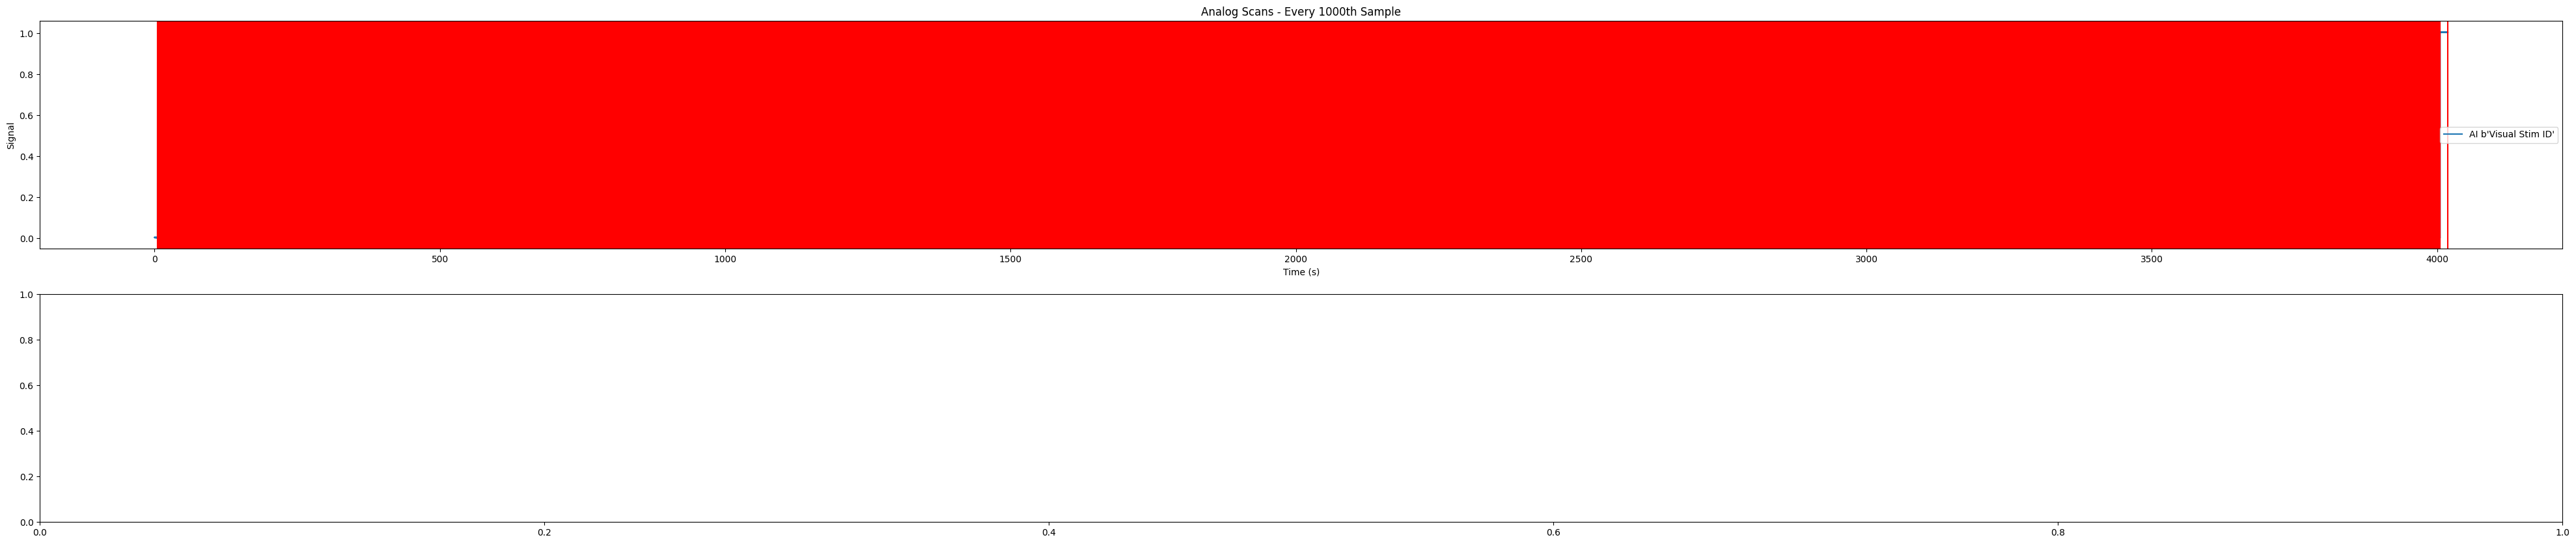

In [15]:
step = 1000
i = 0
# Create timebase
timebase = np.arange(0, len(analog_scans[i]), step) / sr

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(50, 10))
sr = curr_file['header']['AcquisitionSampleRate'][0][0]
ts = ibe.get_timestamps_from_plateaus(analog_scans[0], sr, threshold=0.2, min_duration=500)
# len(ts)
# Plotting analogScans
axes[0].set_title(f"Analog Scans - Every {step}th Sample")
# for i in range(analog_scans.shape[0]):
i = 0
axes[i].plot(timebase, (analog_scans[i][::step]), label=f"AI {analog_labels[i]}")
# axes[i].legend()
axes[i].set_xlabel("Time (s)")
axes[i].set_ylabel("Signal")



if i == 0:
     onsets = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_start_time",order_by = "event_start_time") 
     offsets = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_start_time",order_by = "event_end_time") 
     edges = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_start_time",order_by = "event_start_time")[::stims_per_trial] 
     edgesoff = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_end_time",order_by = "event_end_time")[stims_per_trial-1::stims_per_trial] 
     for xc in ts:
          axes[i].axvline(x=xc, color = 'r')
     #      # axes[i].set_xlim([1800, 2200])
     # # for xc in offsets:
     #      # axes[i].axvline(x=xc, color = 'r')
     #      # axes[i].axvline(x=xc, color = 'w')
     # for xc in edges:
     #      # axes[i].axvline(x=xc, color = 'r')
     #      # axes[i].axvline(x=xc, color = 'b')
     # for xc in edgesoff:
          # axes[i].axvline(x=xc, color = 'r')
          # axes[i].axvline(x=xc, color = 'y')

In [16]:
len(ibe.get_timestamps_from_plateaus(analog_scans[0], sr, threshold=0.2, min_duration=1000))

8002

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(50, 10))
# sr = curr_file['header']['AcquisitionSampleRate'][0][0]
# ts = ibe.get_timestamps_from_plateaus(analog_scans[0], sr, threshold=0.1, min_duration=10)
# len(ts)
# Plotting analogScans
axes[0].set_title(f"Analog Scans - Every {step}th Sample")
# for i in range(analog_scans.shape[0]):
i = 0
axes[i].plot(timebase, (analog_scans[i][::step]), label=f"AI {analog_labels[i]}")
axes[i].legend()
axes[i].set_xlabel("Time (s)")
axes[i].set_ylabel("Signal")

if i == 0:
     onsets = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_start_time",order_by = "event_start_time") 
     offsets = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_start_time",order_by = "event_end_time") 
     edges = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_start_time",order_by = "event_start_time")[::stims_per_trial] 
     edgesoff = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_end_time",order_by = "event_end_time")[stims_per_trial-1::stims_per_trial] 

for xc in ts:
     # axes[i].axvline(x=xc, color = 'r')
     # axes[i].set_xlim([0, 20])
# for xc in offsets:
#      axes[i].axvline(x=xc, color = 'r')
#      axes[i].axvline(x=xc, color = 'w')
# for xc in edges:
#      axes[i].axvline(x=xc, color = 'r')
#      axes[i].axvline(x=xc, color = 'b')
# for xc in edgesoff:
#      axes[i].axvline(x=xc, color = 'r')
#      axes[i].axvline(x=xc, color = 'y')


In [ ]:
ts = ibe.get_timestamps(np.abs(analog_scans[i]), sr, 1)
len(ts)

In [ ]:
ts = ibe.get_timestamps_from_plateaus(analog_scans[0], sr, threshold=0.1, min_duration=500)
len(ts)


In [ ]:
sr

In [ ]:
(event.Event & scan_key & "event_type = 'aux_bonsai_vis'").fetch('event_start_time')
# auxgatetimestamp_end = (event.Event()  &  "event_type='main_track_gate'" &  scanquery ).fetch('event_end_time')

In [ ]:
dj.Diagram(trial) + dj.Diagram(event) +100


In [ ]:
surgery

In [ ]:
dj.Diagram(subject.Subject) + dj.Diagram(event) + dj.Diagram(scan)

In [ ]:
fp = event.BehaviorRecording.File().fetch('filepath')
print(fp)


In [ ]:
scan.Scan()

In [ ]:
event.AlignmentEvent()

In [ ]:
trial.Trial()

In [ ]:
dj.Diagram(event)

In [ ]:
session.Session * session.SessionDirectory

In [ ]:
key='scan9FF6U114'
(scan.Scan & f'scan_id=\"{key}\"')

In [ ]:
scan.Scan()

`CB DEV NOTE:` In demo file, there are no `scan.motor_position_at_zero` values. Set to 0 here to avoid downstream type errors when adding. Future would should set these to null when not present and revise downstream code.

In [ ]:
scan.ScanInfo()

In [ ]:
scan.ScanInfo.Field()

Note the relative path below:

In [ ]:
scan.ScanInfo.ScanFile()

In [ ]:
event.BehaviorRecording.File()


In [ ]:
(event.BehaviorRecording.File ).fetch1("filepath")

# Treadmill handling and ingestion

In [ ]:
behavior.TreadmillDevice()

In [ ]:
behavior.TreadmillRecording.Channel() 

In [ ]:
treadmill = (behavior.TreadmillRecording.Channel() & scan_key).fetch("data")[0]
time = (behavior.TreadmillRecording.Channel() & scan_key).fetch("time")[0]

In [ ]:
# smoothing window size (ms)
window = 1000

# convert voltage to degree
treadmillnorm = (treadmill-np.min(treadmill)) / np.max(treadmill) * 360

# compute running speed (see function above)
angular_velocity_smoothed, unwrapped_angle_smoothed = ibe.compute_angular_velocity(time, treadmillnorm, window)


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(25, 10))
# plt.rcParams['agg.path.chunksize'] = 10000  # Add this line if it does not rende

# Plotting the time series
axes[0].plot(time, treadmillnorm)
axes[0].set_ylim([-10, 370])
axes[0].set_ylabel("Wheel position [degree]")
axes[0].set_xlabel("Time [s]")

axes[1].plot(time[:-window+1],unwrapped_angle_smoothed )
# axes[1].set_ylim([-10000, 10000])
axes[1].set_ylabel("Unwrapped wheel position [cumulative degree]")
axes[1].set_xlabel("Time [s]")

axes[2].plot(time[:-window],angular_velocity_smoothed)
axes[2].set_ylim([-100, 500])
axes[2].set_ylabel("Running speed [degree / s]")
axes[2].set_xlabel("Time [s]")

# plt.show() 

In [ ]:
dj.Diagram(behavior) + dj.Diagram(event)-10 + dj.Diagram(trial)